# Data Analyst
    
    
    Data Set Chosen: 

-> Airbnb Sydney Database 



 Data Set Chosen: 

 -> Insiderairbnb 



 Description Of Dataset

 -> This dataset covers a variety of things ranging from host names to neighbourhood as well as price and other important figures.

# Tools 
    Pandas
    Seaborn
    Pandas Profiling
    Numpy
    MatPlotLibrary
    GeoPandas
    Fiona
    Shapely
    OS
    Counter 

# Preparing The Required Libraries

In [220]:
%pylab inline
import pandas
from collections import Counter
import seaborn
import pandas_profiling
import numpy
import matplotlib
import geopandas
import fiona
import shapely
import os
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize']= (50,50)

Populating the interactive namespace from numpy and matplotlib


# 1. Preparing and getting data ready for analysis

In [48]:
mapdata = geopandas.read_file('NSW_LOCALITY_POLYGON_shp.shp')

In [49]:
data = pandas.read_csv('Desktop/listings.csv')

In [50]:
data2 = pandas.read_csv('Desktop/listings2.csv')

price = data2['price']
prices = []

for p in price:
    p = float(p[1:].replace(',', ''))
    prices.append(p)

data2['price'] = prices

In [51]:
data3 = pandas.read_csv('Desktop/calendar.csv')
price = data3['price']
prices = []

for p in price:
    p = re.sub('[^0-9.]+','', p)
    prices.append(float(p))
    
# Using New Column For Price Because Default is too hard to understand
data3['price'] = prices

data3 = data3[data3.price >= 0]

# Renaming Y/D/O/M
data3['Year'],data3['Month'],data3['Day']=data3['date'].str.split('-',2).str

In [52]:
#pandas_profiling.ProfileReport(data)

# Categorising The Data And Generalising The Charts

In [53]:
# data.drop(['availability_365', 'minimum_nights', 'neighbourhood', 'room_type'],axis=1).head()

# Before Visualizing the data, let's go collect and go through some "interesting" and "important" information of this dataset

Number Of Listings And Average Prices In Different Neighbourhood

In [136]:
nh = Counter(data2['neighbourhood_cleansed'])
neighborhood_names = list(nh.keys())

nh_prices = data2[['neighbourhood_cleansed', 'price']]
nh_prices.columns = ['neighbourhood', 'price']
# Selecting The Row W Listings
nh_prices = nh_prices[nh_prices['neighbourhood'].isin(neighborhood_names)]
nh_prices_group = nh_prices.groupby('neighbourhood')
nh_prices = nh_prices_group['price'].agg(np.mean)
nh_prices = nh_prices.reset_index()
nh_prices['number of listings'] = nh.values()
nh_prices.head(5)

# To Show All Uncomment Below
# nh_prices

,neighbourhood,price,number of listings
0,Ashfield,138.286164,9746
1,Auburn,145.030948,1853
2,Bankstown,99.372093,987
3,Blacktown,84.178808,1624
4,Botany Bay,117.838435,1408


We see that Ashfield has the largest listings of over 9000 followed by Auburn then Bankstown. Strangely, it's not within the CBD. 

Now Let's check what's the most common name for host

In [190]:
lastname = []

# Using for loop to filter names and creating a dictionary of them
for detail in summary['host_name']:
    if detail != 0:
        for i in detail.split():
            lastname.append(word)
lastname = Counter(lastname)
word_count = pandas.DataFrame.from_dict(words, orient='index').sort_values(by=0)
word_count.columns = ['host_name']
# From Most Common to least
word_count = word_count.sort_values(by=['host_name'], ascending=False)
word_count.head(20)

,host_name
&,810
David,439
And,418
Michael,271
Sarah,263
The,256
Paul,251
MadeComfy,247
John,229
Peter,223


After analysing the names, we can tell that "&" is very common which generally means there are more than 2 owners of the listing. If we look more into it, there are a lot of "Holiday", "Accommodation" ETC meaning that many holiday companies are using Airbnb as a platform to reach out to get new customers.

# Now, Lets make some visualizing charts to understand and get to know our surroundings of what we are working with 

# First Off, We Will start off with Room Types Analysis

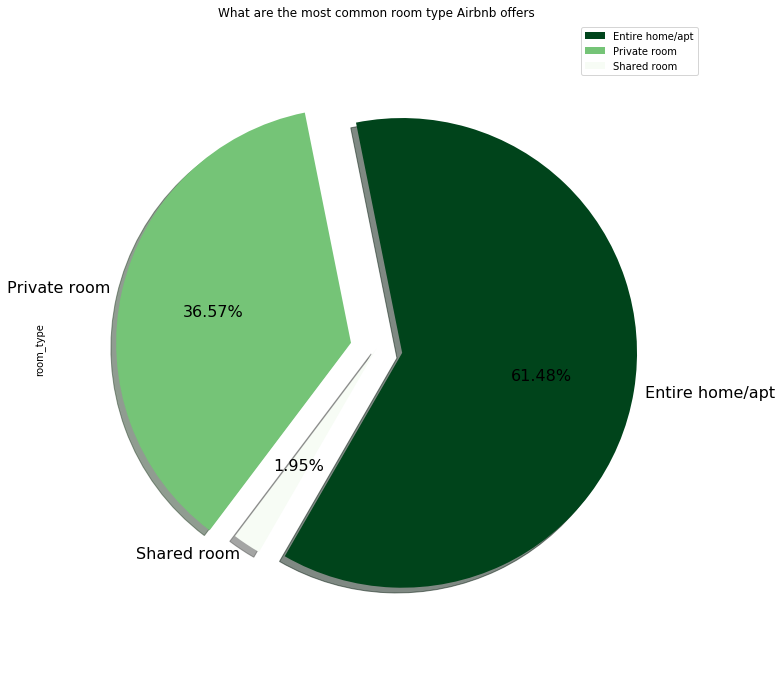

In [283]:
pandas.value_counts(data['room_type']).plot(kind='pie',colormap = 'Greens_r',shadow=True, startangle=240, figsize = (12, 12), radius=0.9, labeldistance=1.05,fontsize = 16, autopct='%.2f%%', legend = 1, explode = (0.1, 0.1,0))
title('What are the most common room type Airbnb offers', color = 'black')
plt.show()

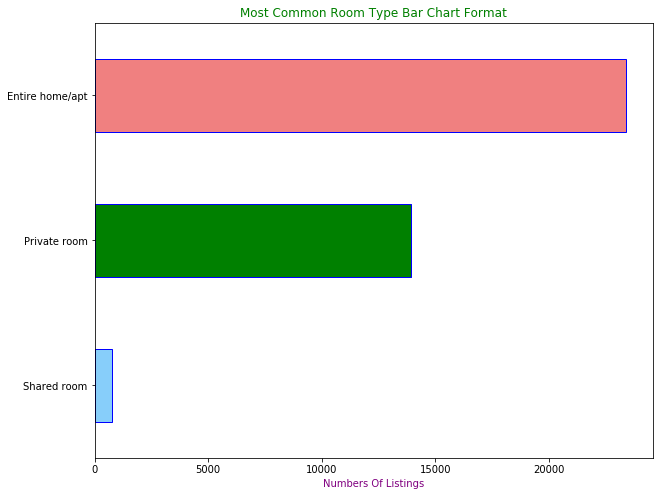

In [286]:
pandas.value_counts(data['room_type']).plot(kind='barh',color=['lightcoral', 'green', 'lightskyblue'], figsize = (10, 8), edgecolor='blue').invert_yaxis()
title('Most Common Room Type Bar Chart Format', color = 'g')
xlabel('Numbers Of Listings', color = 'purple')
plt.show()

Note: As i was trying to run these graphs again, i've been getting this issue called 'str' object is not callable

# Let's Go Deeper into this Data to find out more!

TypeError: 'str' object is not callable

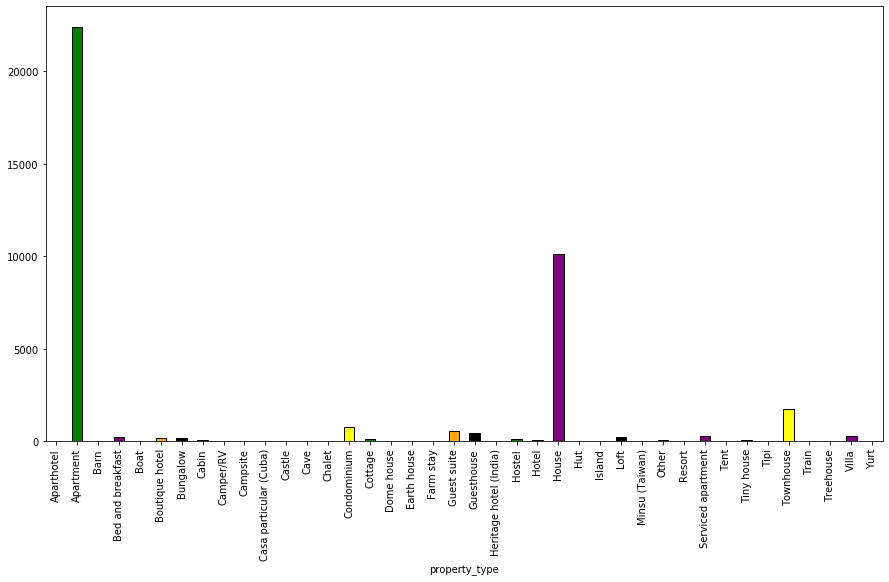

In [288]:
# Setting Up Variables for the data
property_type_data2 = data2.groupby('property_type').id.count()
property_type_data2 = property_type_data2.reset_index()
property_type_data2 = property_type_data2.rename(columns={'id': 'number_of_listings'})
objects = property_type_data2['property_type']
y_pos = property_type_data2['number_of_listings']

# Creating The Bar Chart
property_type_data2.plot.bar(x = 'property_type', y = 'number_of_listings',figsize = (15, 8),legend = False,edgecolor='black', color=['yellow', 'green', 'cyan', 'purple', 'red', 'orange', 'black'])
plt.title('Most Common Property Types (More Detailed)')
xlabel = 'Propert Types'
ylabel = 'Amount Of Listings'
plt.grid(linestyle=':', linewidth=2)
plt.show()

Lets set up a chart that explains the prices of these room types making it easier to understand.

# Let's Now Make A Heat Map For These Room Types With Price Mean

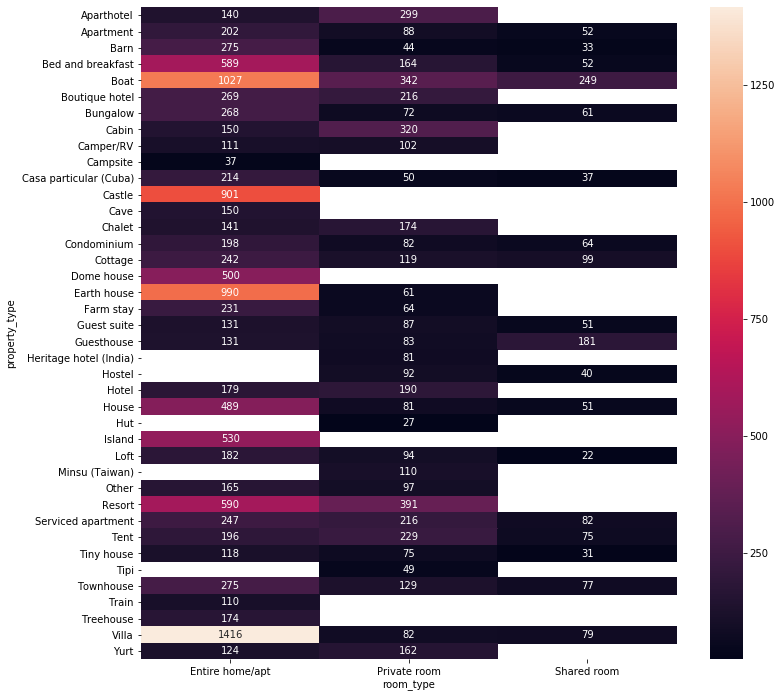

In [59]:
plt.figure(figsize=(12, 12))
seaborn.heatmap(data2.groupby(['property_type', 'room_type']).price.mean().unstack(), annot=True, fmt='.0f')
plt.show()

# Lets Move Onto The Suburbs Analysis!

We will start off with a bar chart explaining the listings across Sydney first.

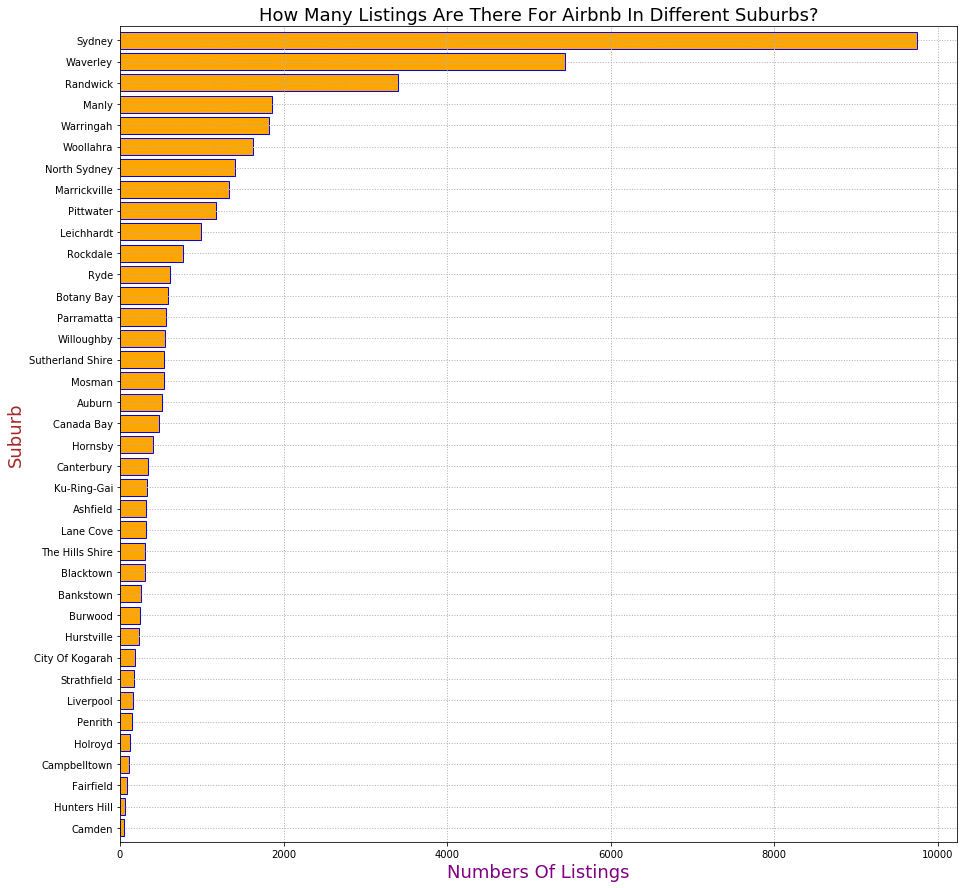

In [60]:
pandas.value_counts(data['neighbourhood']).plot(kind='barh', color = 'orange', width=0.8,figsize=(15,15),edgecolor='blue').invert_yaxis()
plt.title('How Many Listings Are There For Airbnb In Different Suburbs?',size = 18, color = 'black')
ylabel('Suburb', color = 'brown',size=18)
xlabel('Numbers Of Listings', color = 'purple',size=18)
plt.grid(linestyle=':', linewidth=1)
plt.show()

Let's go into more details and do the average price of these suburbs as well while checking how many bedrooms per listings

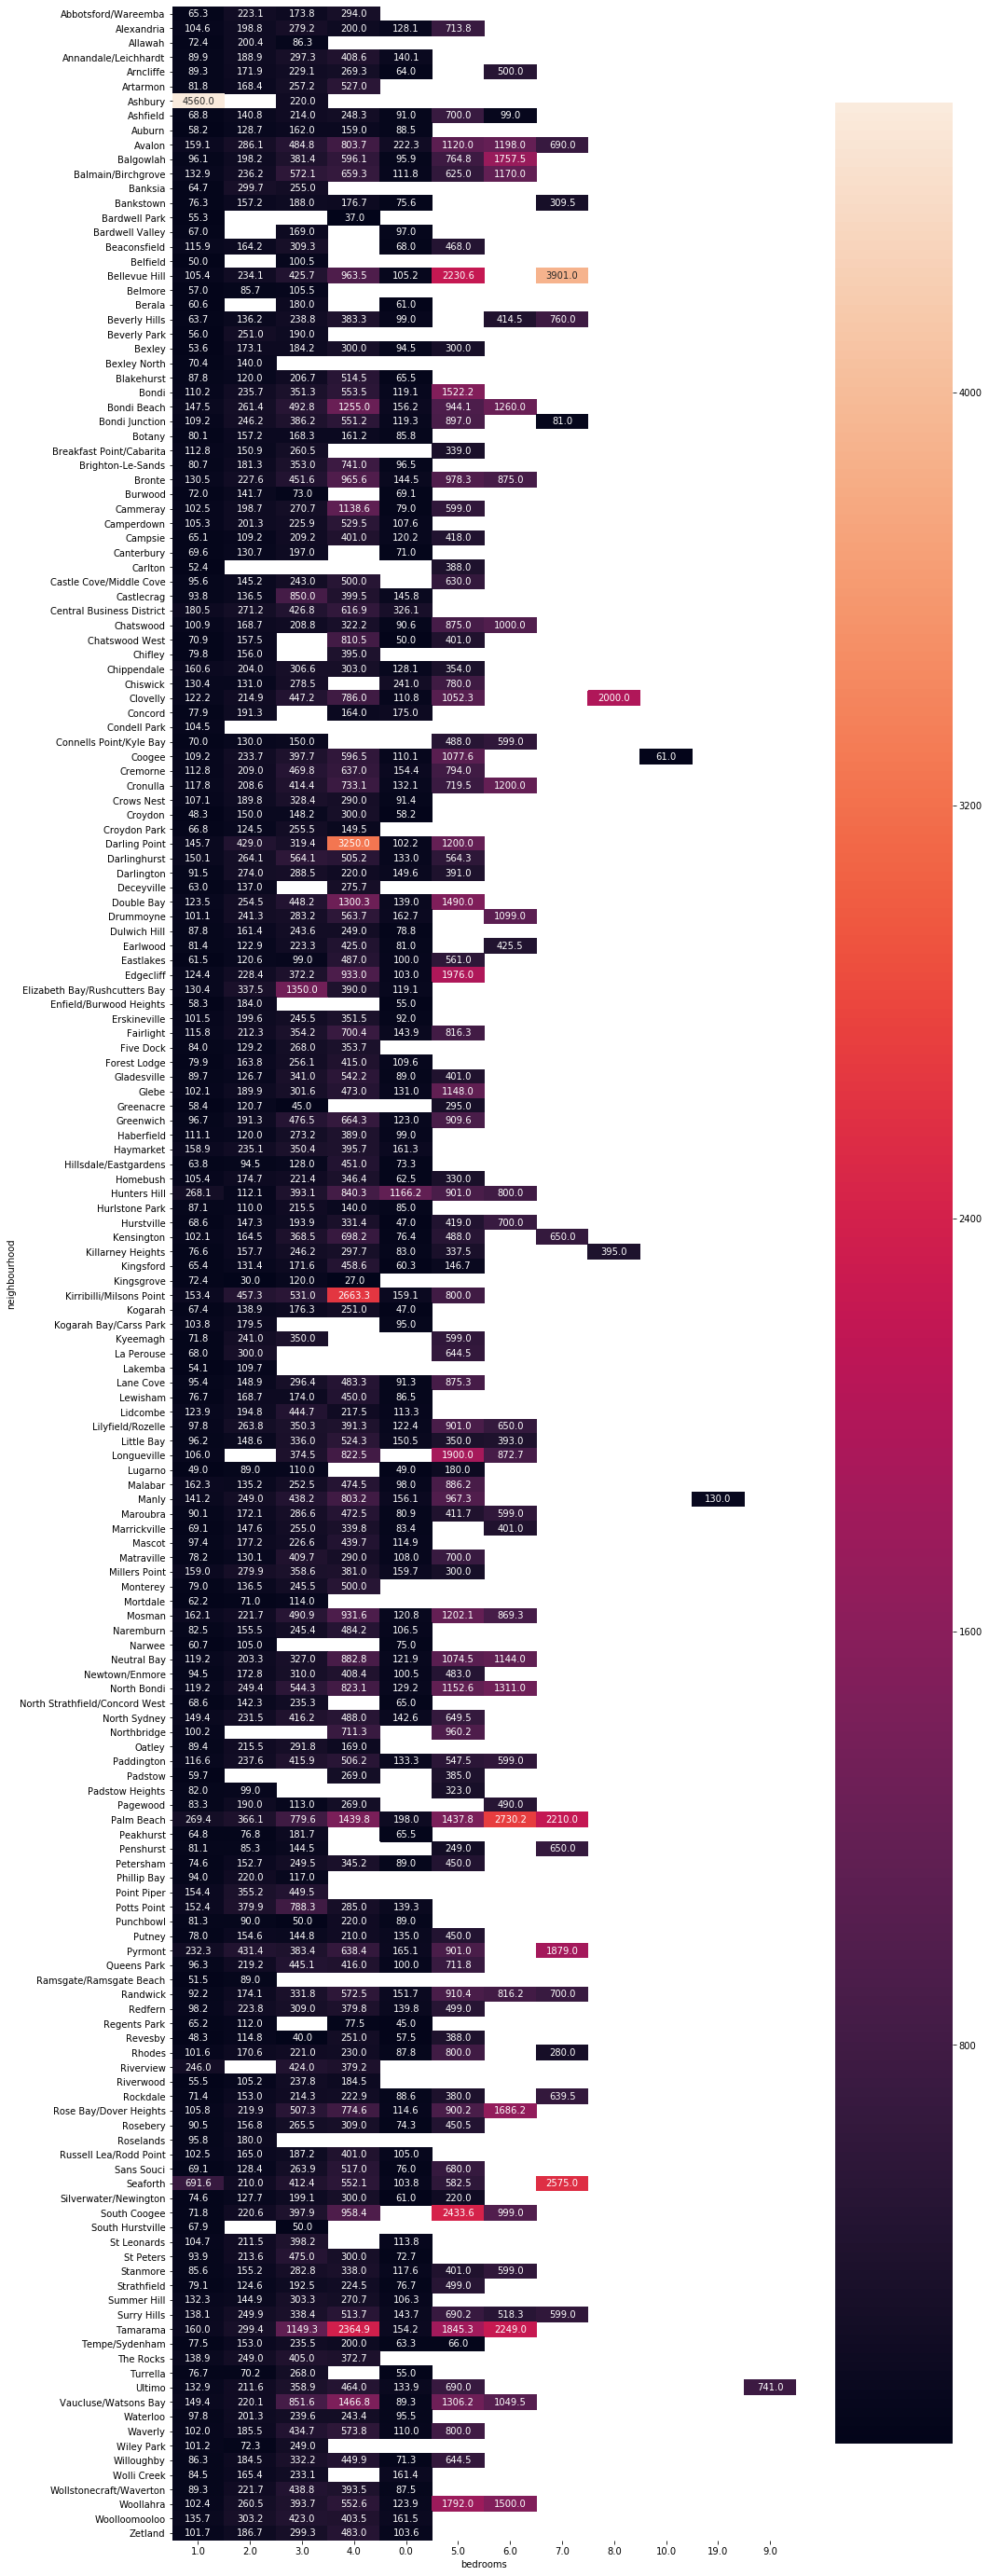

In [61]:
plt.figure(figsize=(15, 50))
seaborn.heatmap(data2.groupby(['neighbourhood', 'bedrooms']).price.mean().unstack(), annot=True, fmt=".1f")
plt.show()

# Price Trends  + Cancellation Policy + Reviews In Accordance To Price Range

In [62]:
yeardata3=data3.groupby(['Year','Month']).price.mean()
yeardata3=yeardata3.reset_index()
yeardata3=yeardata3.rename(columns={'price':'average_Price'})
yeardata3['year-Month']=yeardata3['Year'].map(str) + "-" + yeardata3['Month'].map(str)
yeardata3.to_csv('year_month_data.csv')
yeardata3.head()

,Year,Month,average_Price,year-Month
0,2019,07,194.768872,2019-07
1,2019,08,197.416662,2019-08
2,2019,09,200.284955,2019-09
3,2019,10,202.558245,2019-10
4,2019,11,207.650058,2019-11


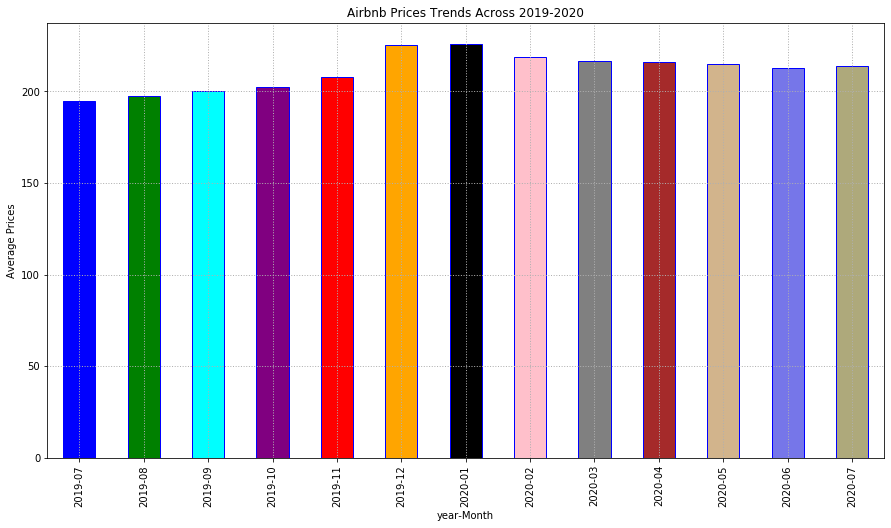

In [63]:
objects = yeardata3['year-Month']
y_pos = yeardata3['average_Price']
yeardata3.plot(kind='bar', x='year-Month',y='average_Price',edgecolor='blue', color=['blue', 'green', 'cyan', 'purple', 'red', 'orange', 'black','pink','gray','brown','tan','#7676E9', '#AEA97B','#5D6FE3'], figsize =(15,8), title = 'Airbnb Prices Trends Across 2019-2020', legend = False)
ylabel('Average Prices')
plt.grid(linestyle=':', linewidth=1)
plt.show()

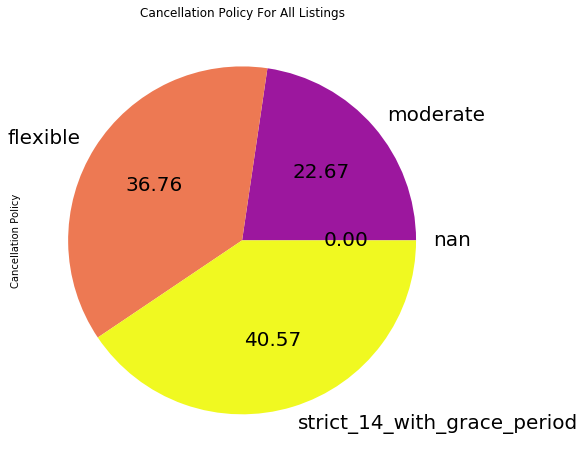

In [129]:
canceldata = data2.cancellation_policy
cp = Counter(canceldata)
cp.pop("super_strict_30", None)
cp.pop("super_strict_60", None)
cp.pop("luxury_no_refund", None)
cp.pop("luxury_moderate", None)
cp.pop("nan", None)
cp.pop("luxury_super_strict_125", None)
cp.pop("luxury_super_strict_95", None)

canceldata_data2 = pandas.DataFrame.from_dict(cp, orient='index').sort_values(by=0)
canceldata_data2.columns = ['Cancellation Policy']
canceldata_data2.plot.pie(y = 'Cancellation Policy',
                   colormap = 'plasma',
                   figsize=(8,8), 
                   fontsize = 20, 
                   autopct = '%.2f',
                   legend = False,
                   title = "Cancellation Policy For All Listings")

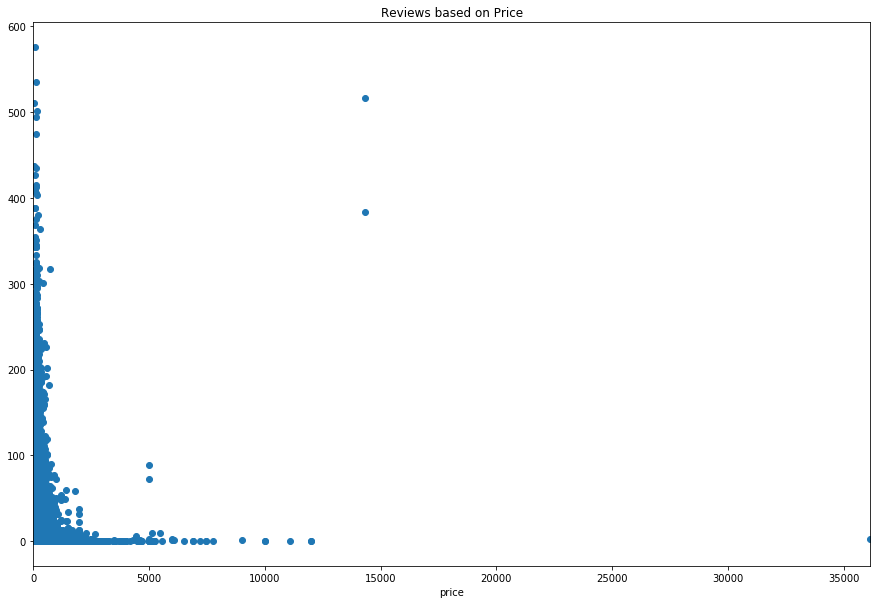

In [108]:
price_review = data2[['number_of_reviews', 'price']].sort_values(by = 'price')
price_review.plot(x = 'price', y = 'number_of_reviews', style = 'o',figsize =(15,10),legend = False, title = 'Reviews based on Price')

This Indicates that majority of the people book rooms with a range of $100 to $300 as most reviews are clustered around that range. As the price increase, the more scarce the reviews are.

In [260]:
def timeplot(data, feat, title):
    
    plt.figure(figsize=(15,8))
    
    x = [datetime.strptime(date, '%Y-%m-%d') for date in data.index]
    y = data[feat]
    y_smooth = gaussian_filter1d(y, sigma=5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.plot(x, y_smooth, 'c-')
    plt.show()

# Note: I got this tutorial from StackOverflow

# Monthly Median Price 

In [261]:
price_median = data3[['date', 'price']].groupby('date').median()

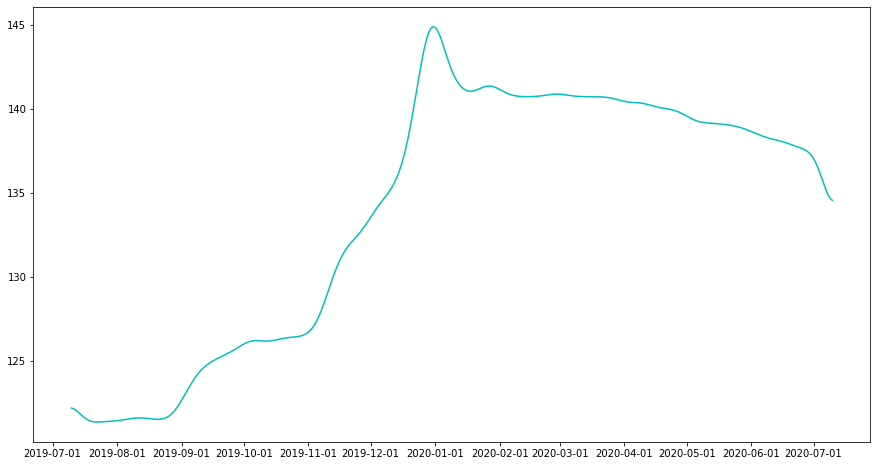

In [262]:
timeplot(price_median, 'price', title = 'Median Price Average')

# Average Price Monthly

In [263]:
price_average = data3[['date', 'price']].groupby('date').mean()

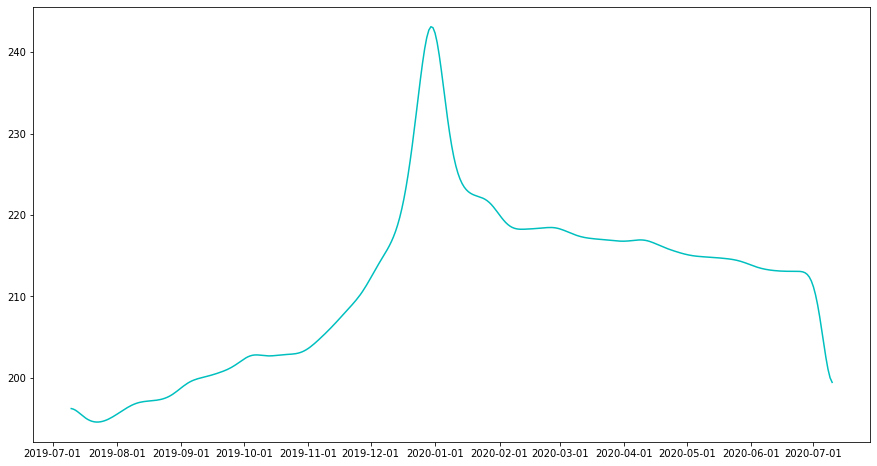

In [264]:
timeplot(price_average, 'price', title = 'Median Price Average')

After analysing both Mean and Median price, the pattern is quite similar and the uprising trend in December to January are properly because of Christmas and Chinese New Years.

# Now let's focus onto the locations of these Airbnb hostings across Sydney

  When looking at locations of Airbnb Hostings, we will be visualizing the different locations of the listings onto a map making it easier for readers to understand. 

# Histogram Of The Latitude + Longitude Of Airbnb Listings

''

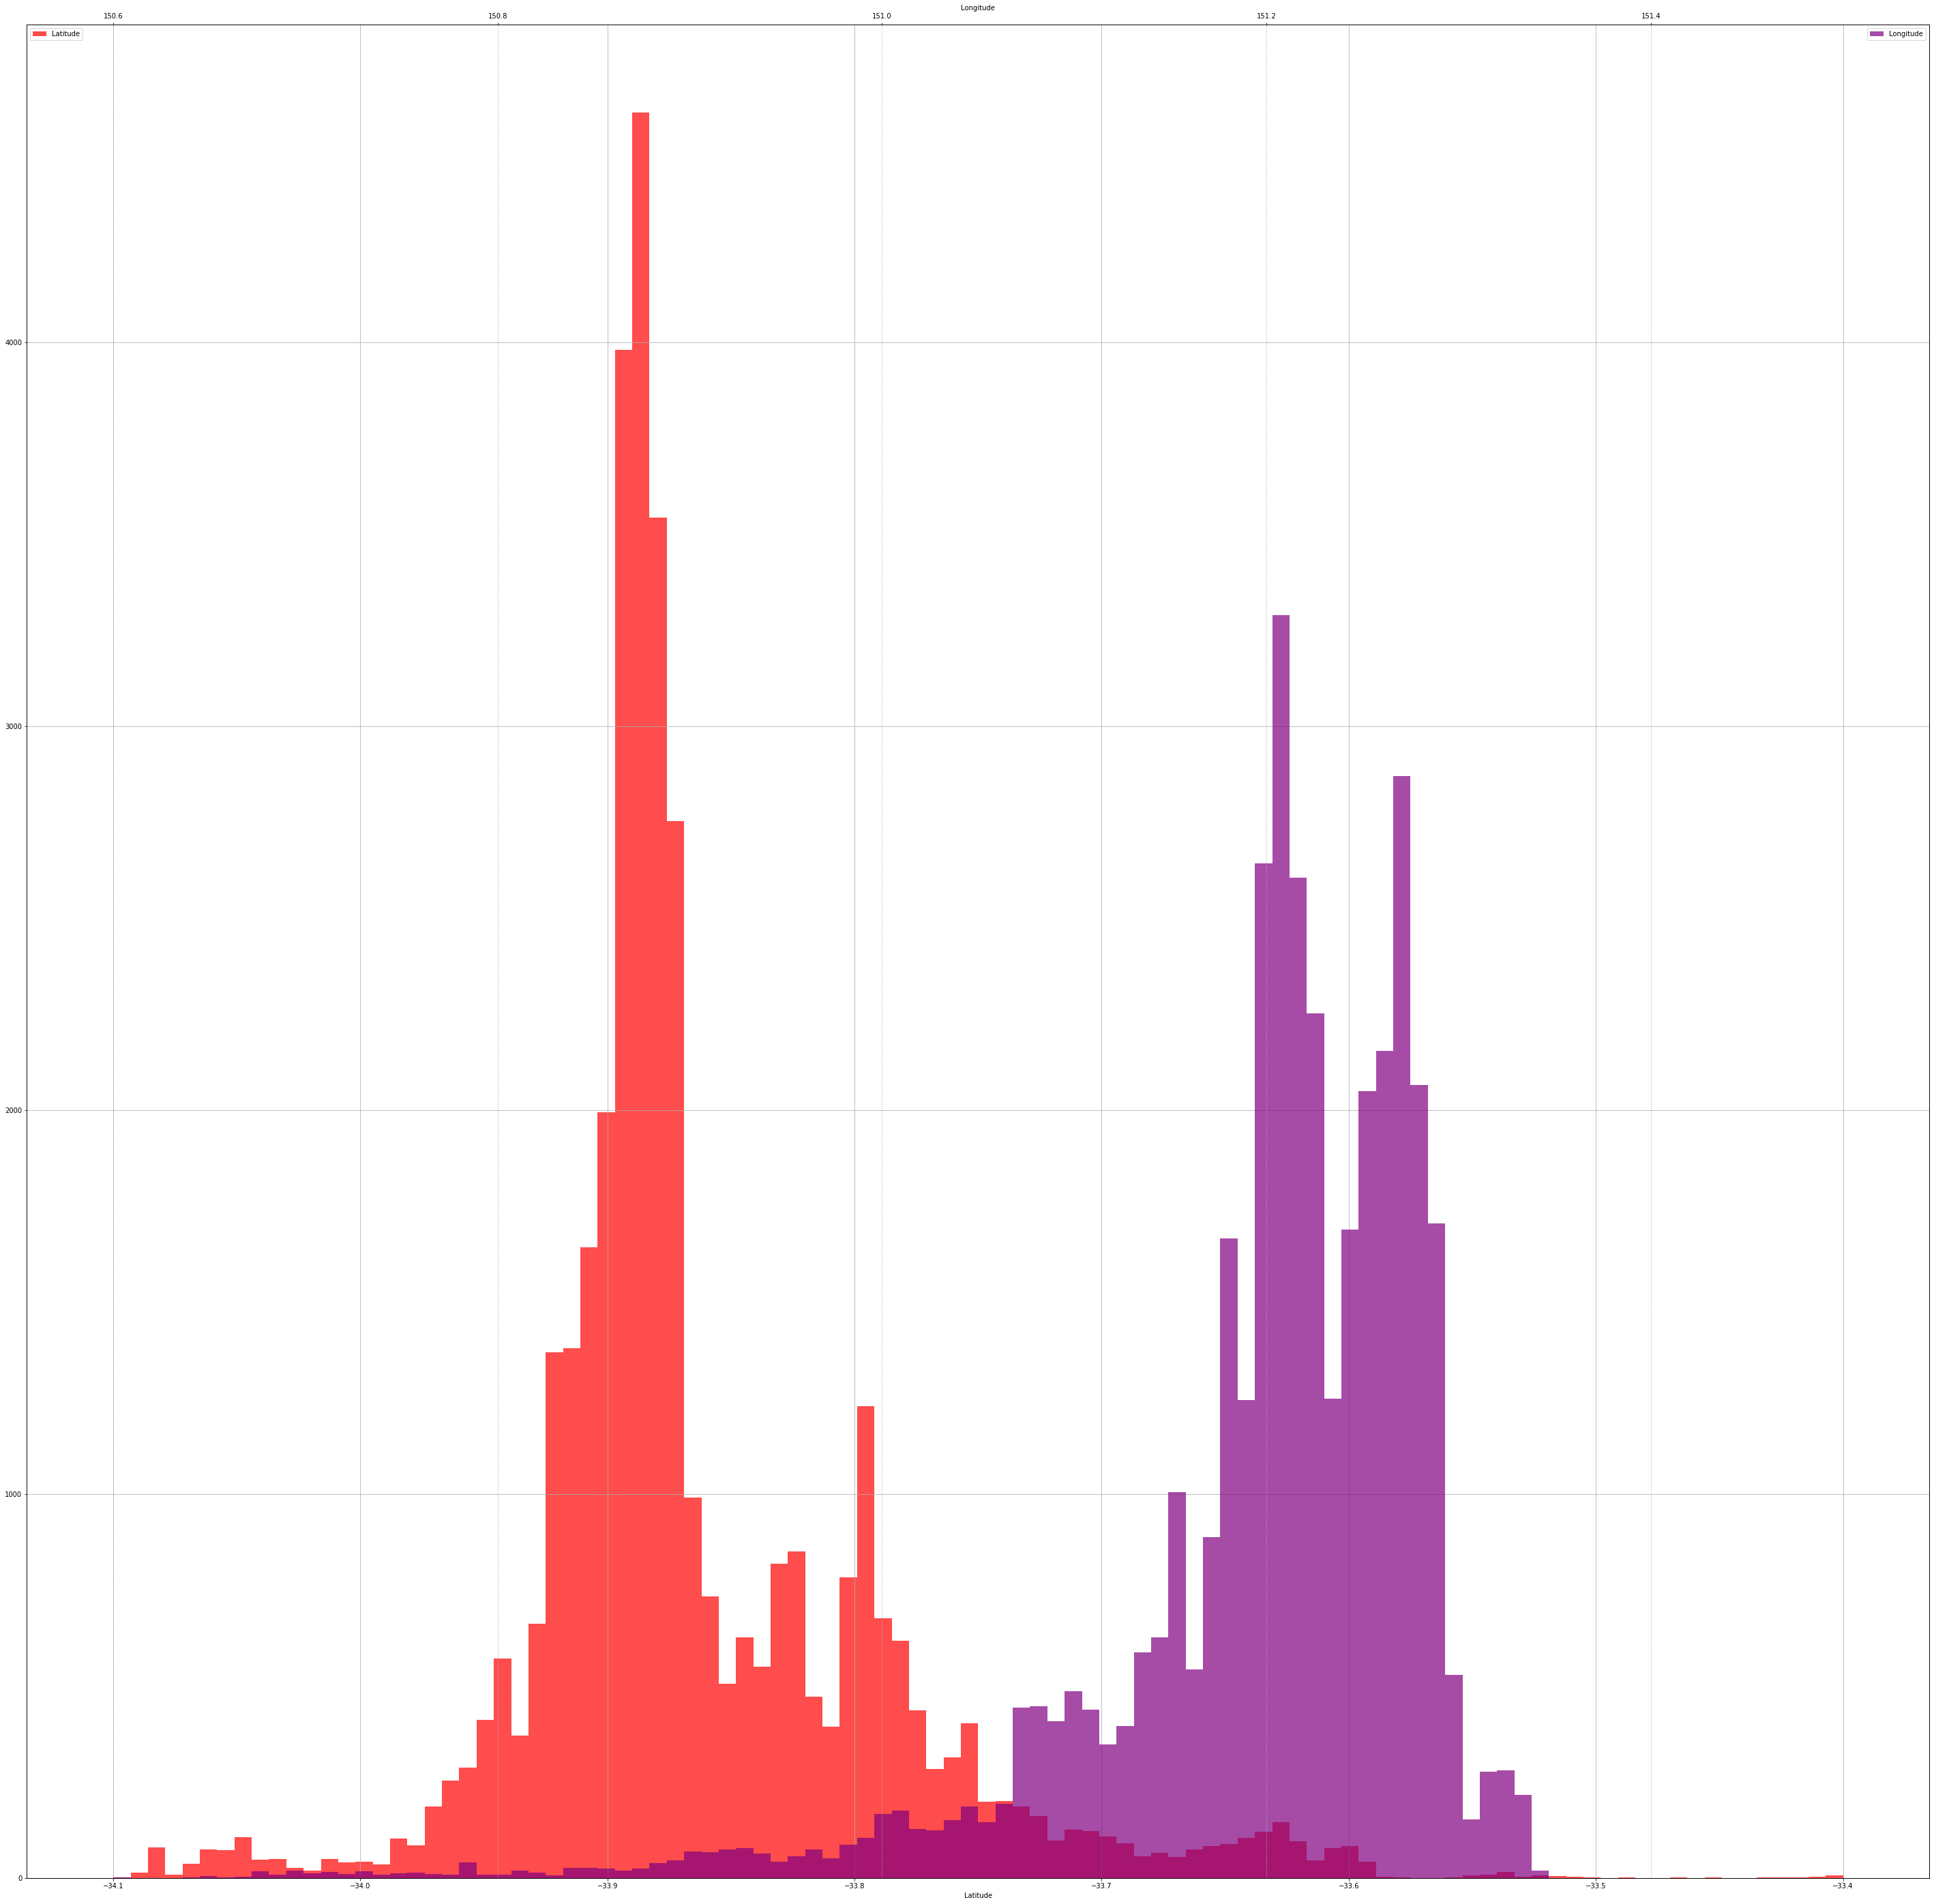

In [194]:
hist(data['latitude'], bins = 100, range = (-34.1, -33.4), rwidth = 1, alpha = .7, color = "Red", label = 'Latitude')
xlabel("Latitude")
grid()
legend(loc="upper left")
twiny()
hist(data['longitude'], bins = 100, range = (150.6, 151.5), rwidth = 1, alpha = .7, color = "Purple", label = 'Longitude')
xlabel("Longitude")
grid()
legend(loc="upper right")
plt.grid(linestyle=':', linewidth=1)
;

# A Simple Map Of All Listings Jumbled Together 

As you can see on the graph, the listings is usually gathered inside of the CBD where most Airbnb hostings are listed. 
But this does not really tell us everything about the hosting. So let's dig deeper and go more in-depth. We will be able to explore deeper by exploring each room types and checking them individually on the map which will tell us more.

Text(0, 0.5, 'Latitude')

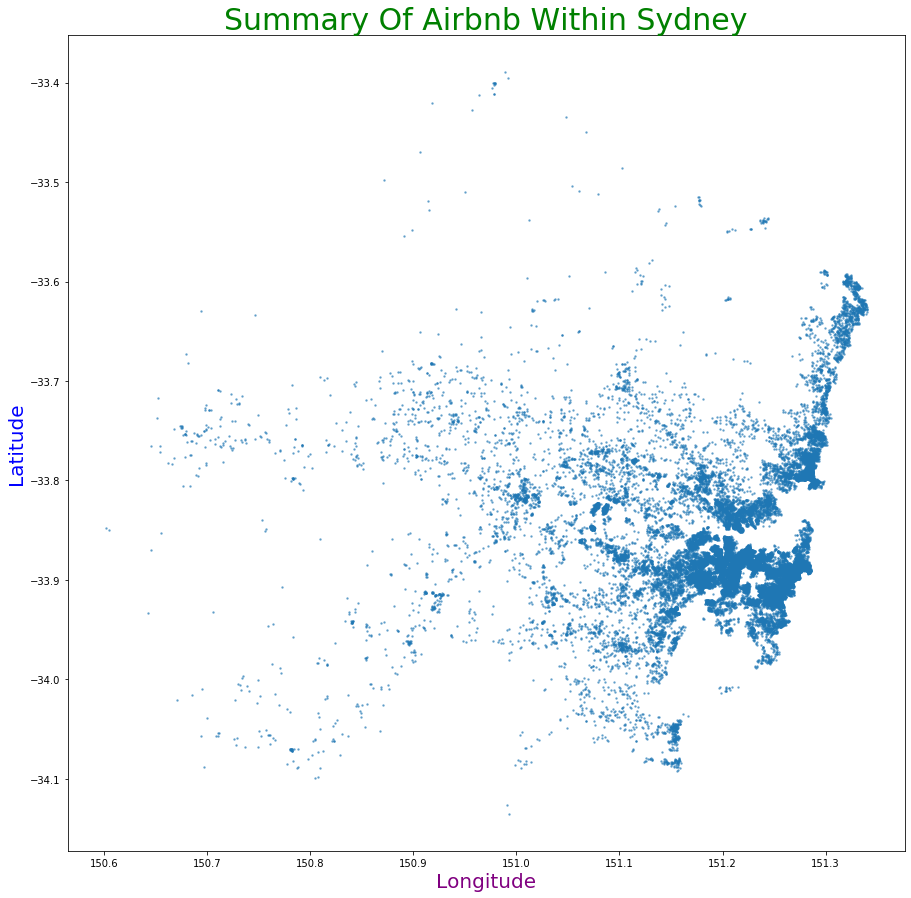

In [197]:
figure(figsize=(15,15))
plot((data['longitude']), data['latitude'], '.',ms=3, alpha=.5)
title('Summary Of Airbnb Within Sydney', color = 'green',size=30)
xlabel('Longitude', color = 'purple', size=20)
ylabel('Latitude', color = 'b', size=20)

#Aparrtment show red House color other 

# Using for loop to seperate and sort out each room type for future usage

In [198]:
list = []
for type in data['room_type']:
    if type >= str("Private Room"):
        list.append(True)
    else:
        list.append(False)

list2 = []
for type in data['room_type']:
    if type >= str("Shared Room"):
        list2.append(True)
    else:
        list2.append(False)
        
list3 = []
for type in data['room_type']:
    if type == str("Entire home/apt"):
        list3.append(True)
    else:
        list3.append(False)

        # Creating Variables
privateapt = pandas.Series(list)
shared = pandas.Series(list2)
entire = pandas.Series(list3)

# Map Showing Each Room Types On The Map

                                    Green stands for Private Apartments
                                    
                                    Purple stands for Shared Room
                                    
                                    Red stands for Entire Apt / House
                                    
                                    

By seperating these 3 room types, we acknowledge that shared rooms and apartments are the most common within the Sydney CBD. Furthermore, we also see that shared room are less common as understood from above that shared room tend to be less popular amongst people as "no one likes to share a room with a stranger". But if we look deeper, we can see that there are alot of entire apartments and houses in the upper bit of Sydney which presumably would be the Central Coast area, this is because that area is much more open and filled with empty lands and bigger houses. With this data in hand, we will soon explore the prices as well and compare how they match up against each other in different region of NSW / Sydney.

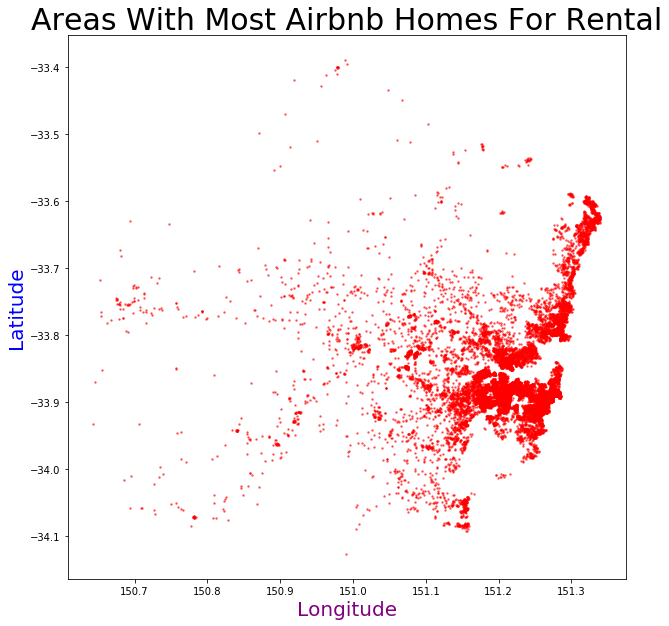

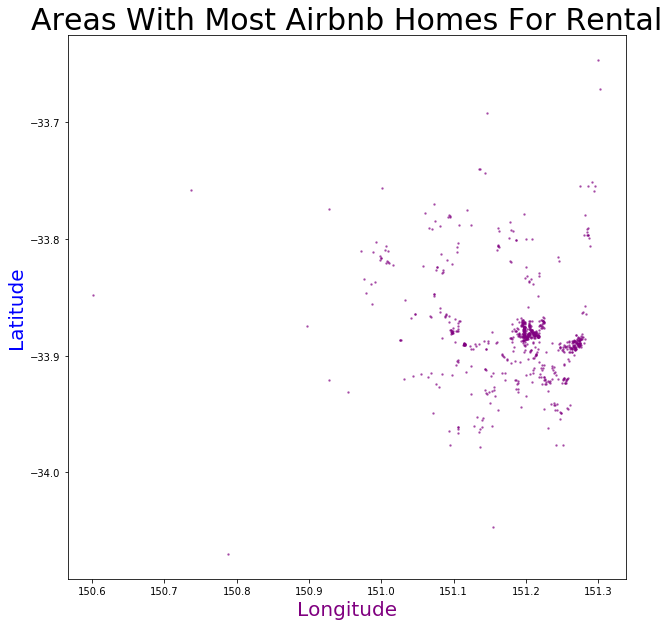

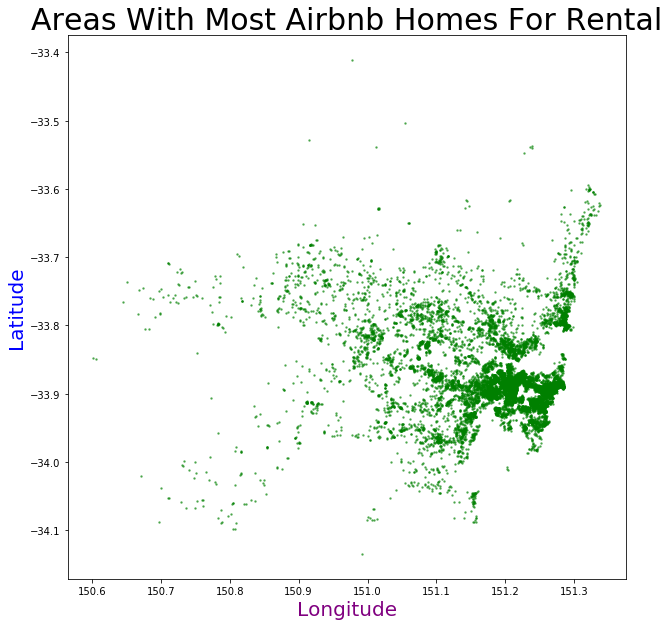

In [201]:
loc1 = data[entire]
loc2 = data[shared]
loc3 = data[privateapt]

figure(figsize=(10,10))
plot((loc1['longitude']), loc1['latitude'], '.',color = 'red', ms=3, alpha=.5)
title('Areas With Most Airbnb Homes For Rental', color = 'black',size=30)
ylabel('Latitude', color = 'b',size=20)
xlabel('Longitude', color = 'purple', size=20)
plt.show()

figure(figsize=(10,10))
plot((loc2['longitude']), loc2['latitude'], '.',color = 'purple', ms=3, alpha=.5)
title('Areas With Most Airbnb Homes For Rental', color = 'black',size=30)
ylabel('Latitude', color = 'b',size=20)
xlabel('Longitude', color = 'purple', size=20)
plt.show()

figure(figsize=(10,10))
plot((loc3['longitude']), loc3['latitude'], '.',color = 'green', ms=3, alpha=.5)
title('Areas With Most Airbnb Homes For Rental', color = 'black',size=30)
ylabel('Latitude', color = 'b',size=20)
xlabel('Longitude', color = 'purple', size=20)
plt.show()

# All Room Types In A Plotted Map

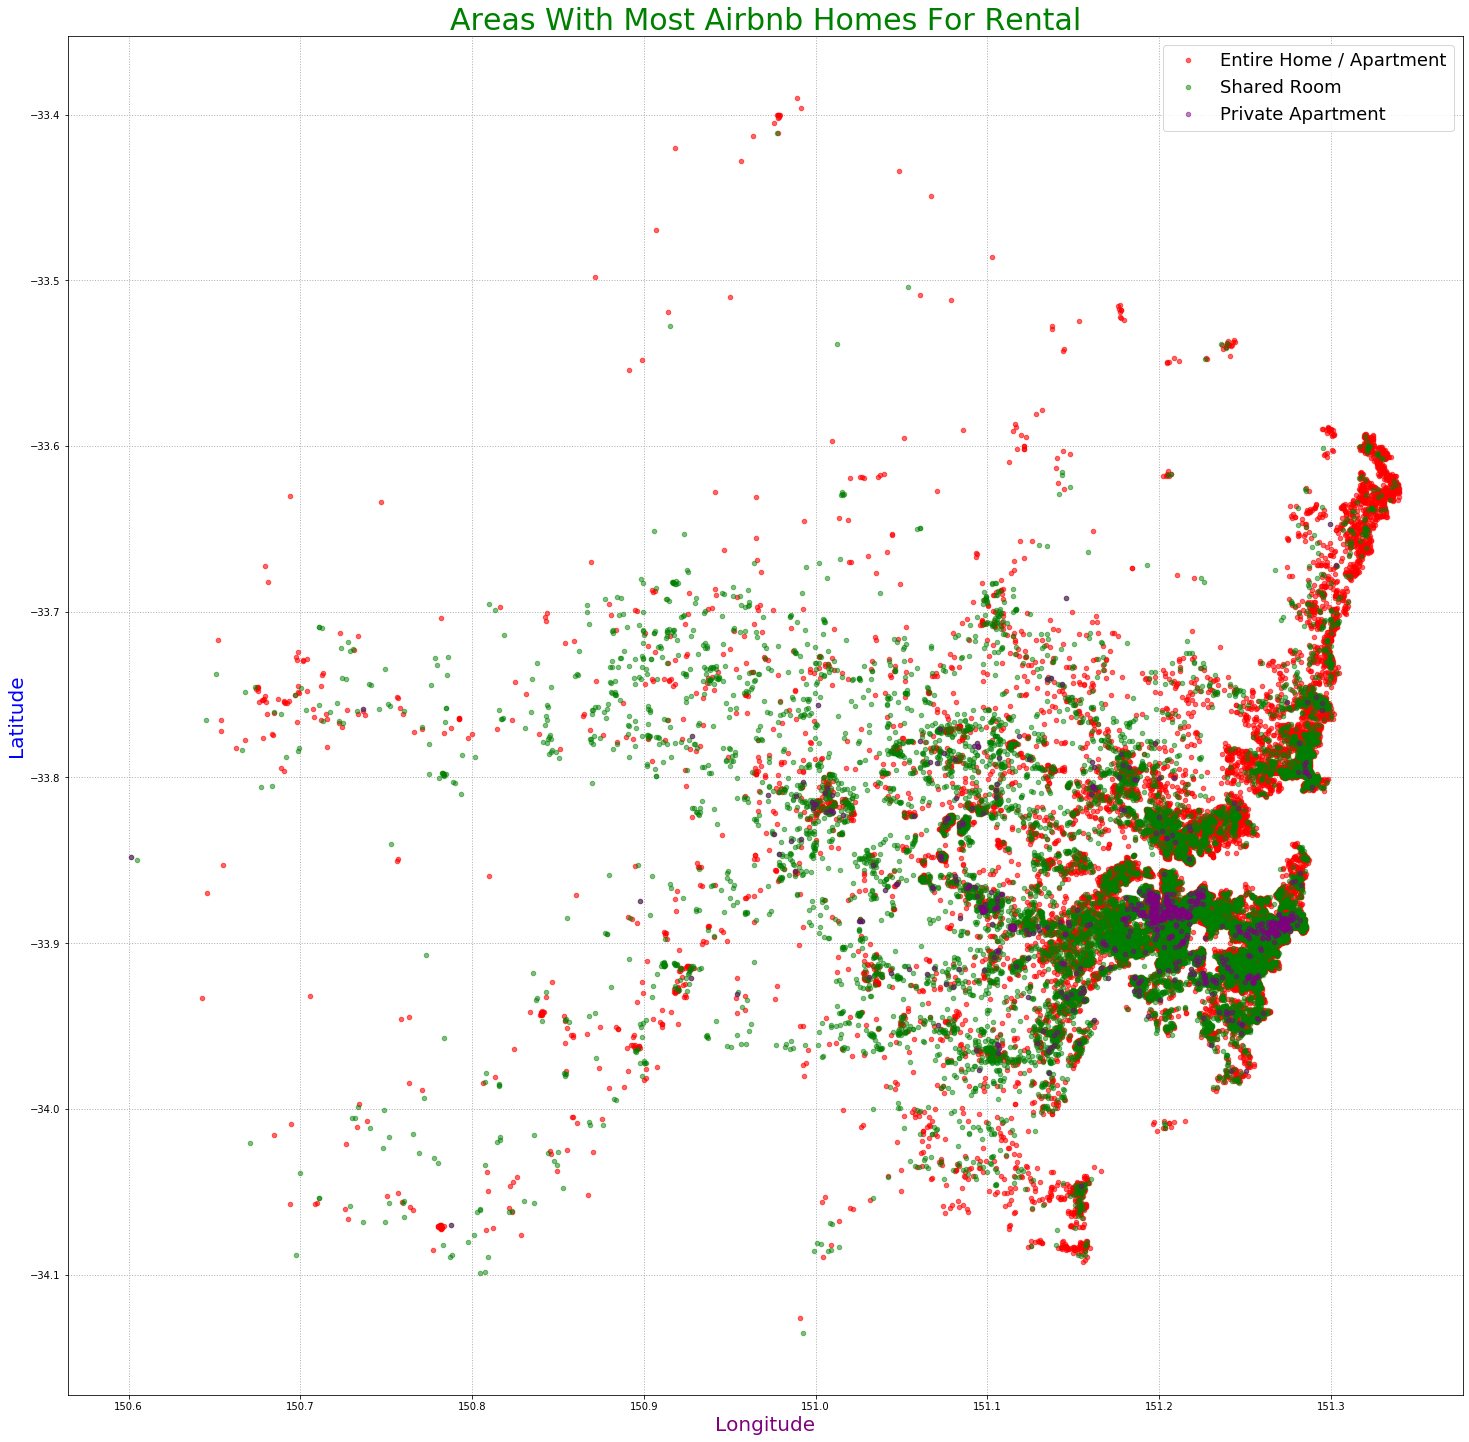

In [203]:
loc1 = data[entire]
loc2 = data[shared]
loc3 = data[privateapt]
mapimg = geopandas.GeoDataFrame.from_file('NSW_LOCALITY_POLYGON_shp.shp')

figure(figsize=(25,25))
plot((loc1['longitude']), loc1['latitude'], '.',color = 'red', ms=9, alpha=.6, label = 'Entire Home / Apartment')
plot((loc3['longitude']), loc3['latitude'], '.',color = 'green', ms=9, alpha=.5, label = 'Shared Room')
plot((loc2['longitude']), loc2['latitude'], '.',color = 'purple', ms=9, alpha=.5, label = 'Private Apartment')
plt.legend(fontsize=18)
title('Areas With Most Airbnb Homes For Rental', color = 'green',size=30)
ylabel('Latitude', color = 'b',size=20)
xlabel('Longitude', color = 'purple', size=20)
grid(linestyle=':', linewidth=1)
plt.show()


# Mapping Together The Regions

After completing the map, let's make these details more visualizing by adding a few unique and harder features to imply for this type of category of dataset.

In [204]:
burbs = geopandas.GeoDataFrame.from_file('NSW_LOCALITY_POLYGON_shp.shp')
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
burbs.tail(2)

town1 = burbs.iloc[0]

def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)
right_here = shapely.geometry.point.Point(151.2299732, -33.9178754)
burbs["distance_from_UNSW"] = burbs.geometry.distance(right_here)

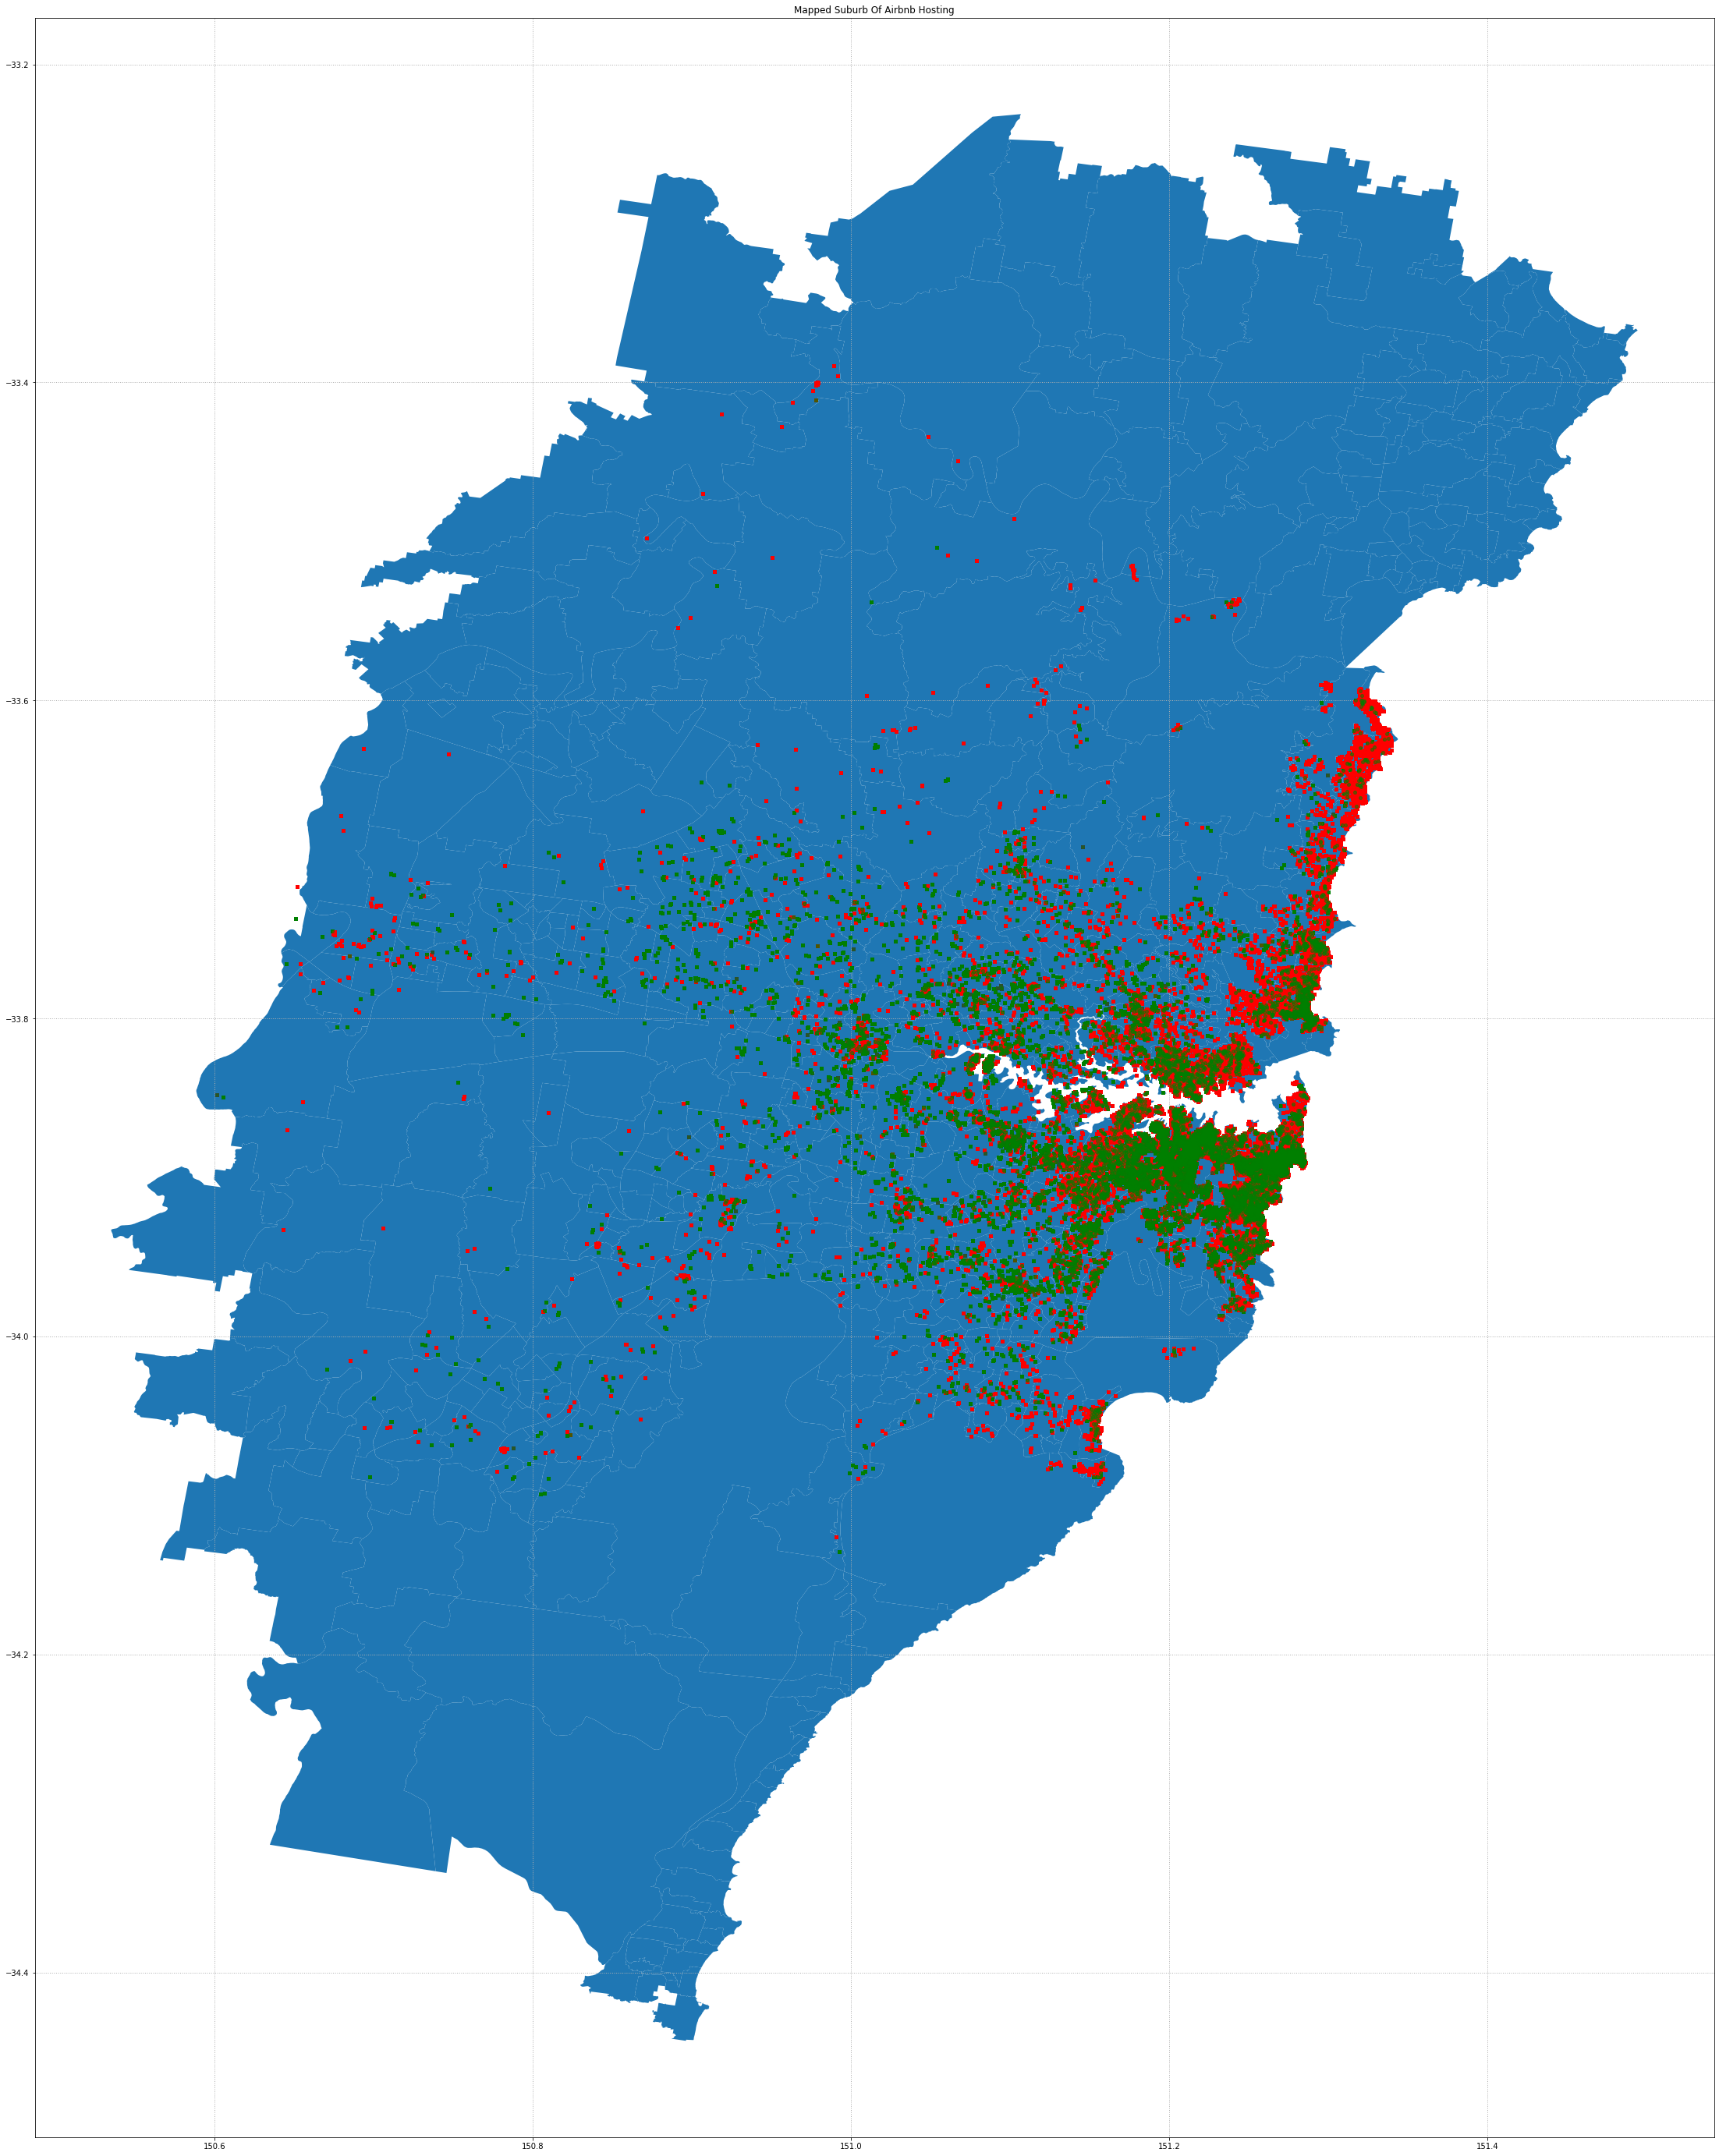

In [208]:
really_close_burbs = burbs[burbs.distance_from_UNSW<0.6]
really_close_burbs.plot()

for idx, row in really_close_burbs.iterrows():
    plot((loc1['longitude']), loc1['latitude'], '.',color = 'red', ms=8, alpha=.5, label = 'Entire Home / Apartment')
    plot((loc2['longitude']), loc2['latitude'], '.',color = 'purple', ms=8, alpha=.5, label = 'Private Apartment')
    plot((loc3['longitude']), loc3['latitude'], '.',color = 'green', ms=8, alpha=.5, label = 'Shared Room')
    plt.grid(linestyle=':', linewidth=1)
    title("Mapped Suburb Of Airbnb Hosting");

In [ ]:
print(right_here)
in_this_burb = None
for _, row in really_close_burbs.iterrows():
    if right_here.within(row.geometry):
        in_this_burb = row
        
in_this_burb = really_close_burbs[really_close_burbs.apply(lambda x: right_here.within(x.geometry) , axis=1)]
in_this_burb

# Other Stuff [ Testing ]

In [31]:
# data[shared].groupby("neighbourhood").mean()

In [32]:
# data[["neighbourhood", "price"]].head(10).plot(kind="barh")

In [33]:
# panda merge

In [34]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11156,An Oasis in the City,40855,Colleen,NaN,Sydney,-33.86917,151.22656,Private room,65,2,185,2019-04-24,1.58,1,354
1,12351,Sydney City & Harbour at the door,17061,Stuart,NaN,Sydney,-33.86515,151.19190,Private room,14316,2,516,2019-06-29,4.73,2,19
2,14250,Manly Harbour House,55948,Heidi,NaN,Manly,-33.80093,151.26172,Entire home/apt,470,5,2,2019-01-02,0.05,2,99
3,15253,Stunning Penthouse Apartment In Heart Of The City,59850,Morag,NaN,Sydney,-33.88045,151.21654,Private room,110,2,323,2019-05-23,3.60,3,336
4,20865,3 BED HOUSE + 1 BED STUDIO Balmain,64282,Fiona,NaN,Leichhardt,-33.85907,151.17275,Entire home/apt,450,7,16,2019-01-03,0.17,1,142


# More Other Graphs